In [1]:
import os
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchmetrics import FBetaScore, ConfusionMatrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

from modular import data_setup, engine, model_builder, utils

import random
from timeit import default_timer as timer
from datetime import datetime

In [3]:
# Creating a directory
data_path = Path("data/")
data_path.mkdir(parents=True,exist_ok=True)

In [4]:
#Extracting the contents of a ZIP file named "water_bottle_level.zip" into the specified data path.
# with zipfile.ZipFile("water_bottle_level.zip") as z:
#   z.extractall(data_path)

In [5]:
# Creating a DataFrame with Image Paths and Corresponding Classes from a Directory Structure
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df = pd.DataFrame(image_list)

In [6]:
df.head()

,path,classes
0,data/Half water level/Half water level/bisleri...,Half water level
1,data/Half water level/Half water level/360_F_3...,Half water level
2,data/Half water level/Half water level/nds-on-...,Half water level
3,data/Half water level/Half water level/unnamed...,Half water level
4,data/Half water level/Half water level/bottle-...,Half water level


In [8]:
df.shape

(429, 2)

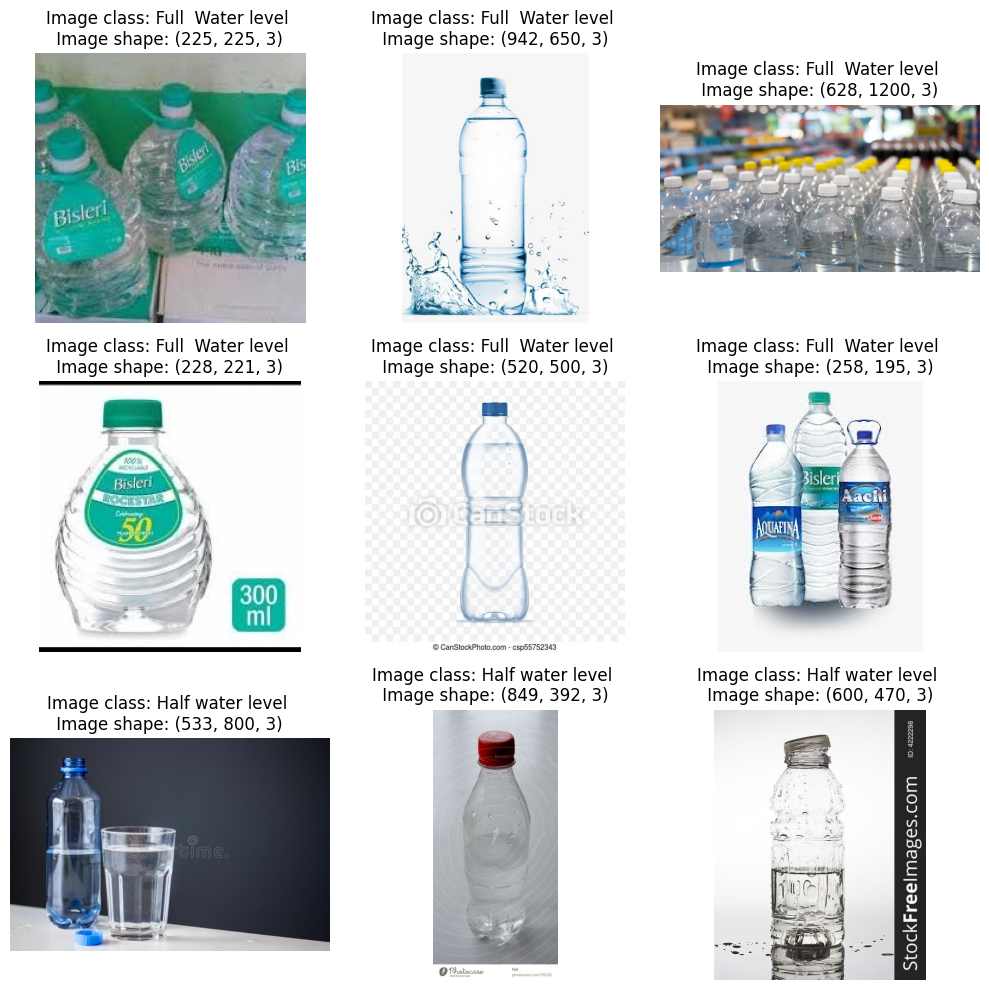

In [9]:
# Displaying a random sample of images along with their classes and shapes in a 3x3 grid.
def plot_image(data):

    rnd_sample = df.sample(9)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, path in zip(axes, rnd_sample["path"]):
        img_class = rnd_sample[rnd_sample["path"] == path]["classes"].iloc[0]

        img = Image.open(path)
        img_as_array = np.array(img)
        ax.imshow(img_as_array)
        ax.set_title(f"Image class: {img_class} \n Image shape: {img_as_array.shape} ")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_image(df)

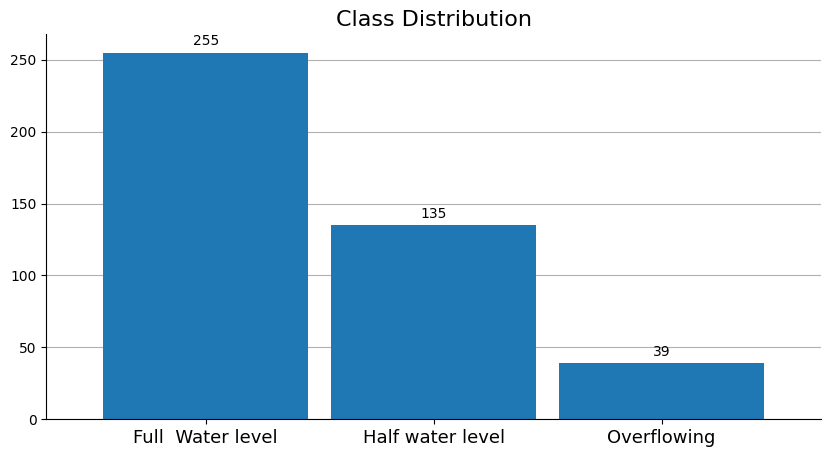

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Class Distribution", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")


* We have a small and imbalanced dataset.
* We need to increase the number of data and choose an appropriate metric for the imbalanced distribution.

In [11]:
full_data_directory = "data/Full  Water level"
half_data_directory = "data/Half water level"
overflowing_data_directory = "data/Overflowing"

In [12]:
# Augmenting datasets by creating additional images for three different classes:
# one from a full data directory, one from a half data directory, and one from an overflowing data directory, each with 500 new images.
data_setup.augment_dataset(class_dir=full_data_directory)
data_setup.augment_dataset(class_dir=half_data_directory)
data_setup.augment_dataset(class_dir=overflowing_data_directory)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df_ = pd.DataFrame(image_list)

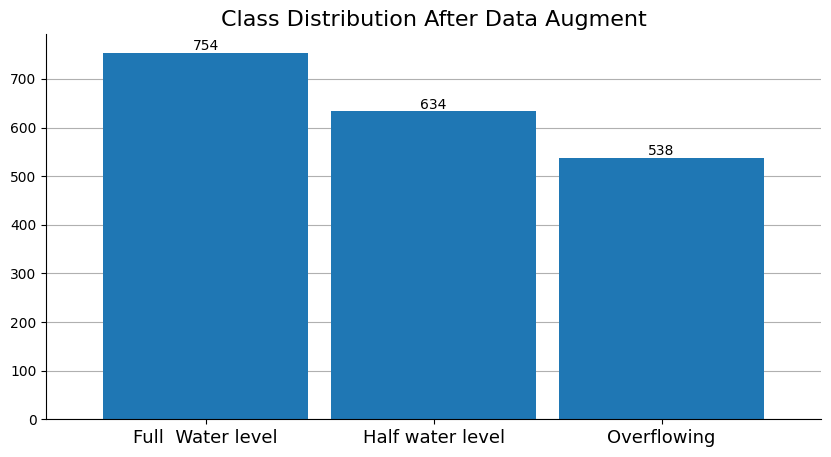

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df_.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Class Distribution After Data Augment", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")

In [15]:
# Creating a model
model, data_transform = model_builder.create_model(model_name="EfficientNet_B0", num_classes=3)

In [16]:
# Creating dataframes
train_df, test_df = data_setup.create_dataframe(data_path=data_path)
# Transforming the training and validation data
train_data_transformed = data_setup.CustomImageFolder(train_df,transform=data_transform)
test_data_transformed = data_setup.CustomImageFolder(test_df,transform=data_transform)

In [17]:
class_names=train_data_transformed.classes

In [18]:
# Creating data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_df,
    test_dir=test_df,
    transform=data_transform,
    batch_size=32,
)

In [19]:
# Setting the computing device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
# Creating an FBetaScore metric for multiclass classification with a specific beta value
fbeta_score = FBetaScore(task="multiclass", num_classes=len(class_names), beta=0.5).to(
    device
)

In [21]:
def create_writer(
    experiment_name="500_data",
    loss_fn="MultiMarginLoss_fn",
    model_name="EfficientNet_B0",
    epoch="50_epochs",
    lr="1e-4_lr",
) -> torch.utils.tensorboard.writer.SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        epoch (str): Epoch number.
        lr (str): Learning rate used in the experiment.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter: Instance of a writer saving to log_dir.


    """
    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime(
        "%d-%m-%Y,%H-%M-%S"
    )  # returns current date in DD-MM-YYYY,H-M-S format

    log_dir_parts = ["runs", timestamp, experiment_name, model_name, loss_fn, epoch, lr]

    # Create log directory path
    log_dir = os.path.join(*log_dir_parts)
    print(log_dir)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

### Train model
* Loss function = Cross Entropy Loss

In [22]:
# Set the loss function and optimizer
cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# Start the timer
start_time = timer()

# Starting training
results_ce = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=cross_entropy_loss,
    epochs=50,
    fbeta_score=fbeta_score,
    device=device,
    writer=create_writer(),
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print("-" * 50 + "\n")

runs/25-08-2023,11-50-28/500_data/EfficientNet_B0/MultiMarginLoss_fn/50_epochs/1e-4_lr
[INFO] Created SummaryWriter, saving to: runs/25-08-2023,11-50-28/500_data/EfficientNet_B0/MultiMarginLoss_fn/50_epochs/1e-4_lr...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
 train_loss: 1.0582 | train_f0.5_score: 44.0% | 
 test_loss: 0.9725 | test_f0.5_score: 63.0% | 
Epoch: 2 
 train_loss: 0.9583 | train_f0.5_score: 63.0% | 
 test_loss: 0.8741 | test_f0.5_score: 73.0% | 
Epoch: 3 
 train_loss: 0.8738 | train_f0.5_score: 71.0% | 
 test_loss: 0.7968 | test_f0.5_score: 77.0% | 
Epoch: 4 
 train_loss: 0.7953 | train_f0.5_score: 76.0% | 
 test_loss: 0.7343 | test_f0.5_score: 79.0% | 
Epoch: 5 
 train_loss: 0.7497 | train_f0.5_score: 78.0% | 
 test_loss: 0.6804 | test_f0.5_score: 81.0% | 
Epoch: 6 
 train_loss: 0.6995 | train_f0.5_score: 79.0% | 
 test_loss: 0.6373 | test_f0.5_score: 82.0% | 
Epoch: 7 
 train_loss: 0.6720 | train_f0.5_score: 80.0% | 
 test_loss: 0.6100 | test_f0.5_score: 82.0% | 
Epoch: 8 
 train_loss: 0.6534 | train_f0.5_score: 79.0% | 
 test_loss: 0.5737 | test_f0.5_score: 83.0% | 
Epoch: 9 
 train_loss: 0.6224 | train_f0.5_score: 80.0% | 
 test_loss: 0.5531 | test_f0.5_score: 82.0% | 
Epoch: 10 
 train_loss: 0.5912 | train_f0.5_sc

### Train model
* Loss function = Multi Margin Loss

In [32]:
!rm -rf data/

In [33]:
with zipfile.ZipFile("water_bottle_level.zip") as z:
  z.extractall(data_path)

In [34]:
full_data_directory = "data/Full  Water level"
half_data_directory = "data/Half water level"
overflowing_data_directory = "data/Overflowing"

In [35]:
# Augmenting datasets by creating additional images for three different classes:
# one from a full data directory, one from a half data directory, and one from an overflowing data directory, each with 500 new images.
data_setup.augment_dataset(class_dir=full_data_directory)
data_setup.augment_dataset(class_dir=half_data_directory)
data_setup.augment_dataset(class_dir=overflowing_data_directory)

In [36]:
# Creating a model
model, data_transform = model_builder.create_model(model_name="EfficientNet_B0", num_classes=3)

In [37]:
# Creating dataframes
train_df, test_df = data_setup.create_dataframe(data_path=data_path)
# Transforming the training and validation data
train_data_transformed = data_setup.CustomImageFolder(train_df,transform=data_transform)
test_data_transformed = data_setup.CustomImageFolder(test_df,transform=data_transform)

In [38]:
class_names=train_data_transformed.classes

In [39]:
# Creating data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_df,
    test_dir=test_df,
    transform=data_transform,
    batch_size=32,
)

In [40]:
# Set the loss function and optimizer
multi_margin_loss = torch.nn.MultiMarginLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# Start the timer
start_time = timer()

# Starting training
results_mm = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=multi_margin_loss,
    epochs=50,
    fbeta_score=fbeta_score,
    device=device,
    writer=create_writer(),
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print("-" * 50 + "\n")

runs/25-08-2023,12-14-02/500_data/EfficientNet_B0/MultiMarginLoss_fn/50_epochs/1e-4_lr
[INFO] Created SummaryWriter, saving to: runs/25-08-2023,12-14-02/500_data/EfficientNet_B0/MultiMarginLoss_fn/50_epochs/1e-4_lr...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [32, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:26.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [4, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to ze

Epoch: 1 
 train_loss: 0.6068 | train_f0.5_score: 43.0% | 
 test_loss: 0.5280 | test_f0.5_score: 62.0% | 
Epoch: 2 
 train_loss: 0.4937 | train_f0.5_score: 61.0% | 
 test_loss: 0.4178 | test_f0.5_score: 69.0% | 
Epoch: 3 
 train_loss: 0.4016 | train_f0.5_score: 71.0% | 
 test_loss: 0.3343 | test_f0.5_score: 76.0% | 
Epoch: 4 
 train_loss: 0.3223 | train_f0.5_score: 76.0% | 
 test_loss: 0.2844 | test_f0.5_score: 78.0% | 
Epoch: 5 
 train_loss: 0.2808 | train_f0.5_score: 78.0% | 
 test_loss: 0.2475 | test_f0.5_score: 79.0% | 
Epoch: 6 
 train_loss: 0.2502 | train_f0.5_score: 80.0% | 
 test_loss: 0.2238 | test_f0.5_score: 85.0% | 
Epoch: 7 
 train_loss: 0.2412 | train_f0.5_score: 81.0% | 
 test_loss: 0.2129 | test_f0.5_score: 81.0% | 
Epoch: 8 
 train_loss: 0.2297 | train_f0.5_score: 81.0% | 
 test_loss: 0.1993 | test_f0.5_score: 85.0% | 
Epoch: 9 
 train_loss: 0.2192 | train_f0.5_score: 81.0% | 
 test_loss: 0.1866 | test_f0.5_score: 86.0% | 
Epoch: 10 
 train_loss: 0.2034 | train_f0.5_sc

### Comparing Two Models with Different Loss Functions

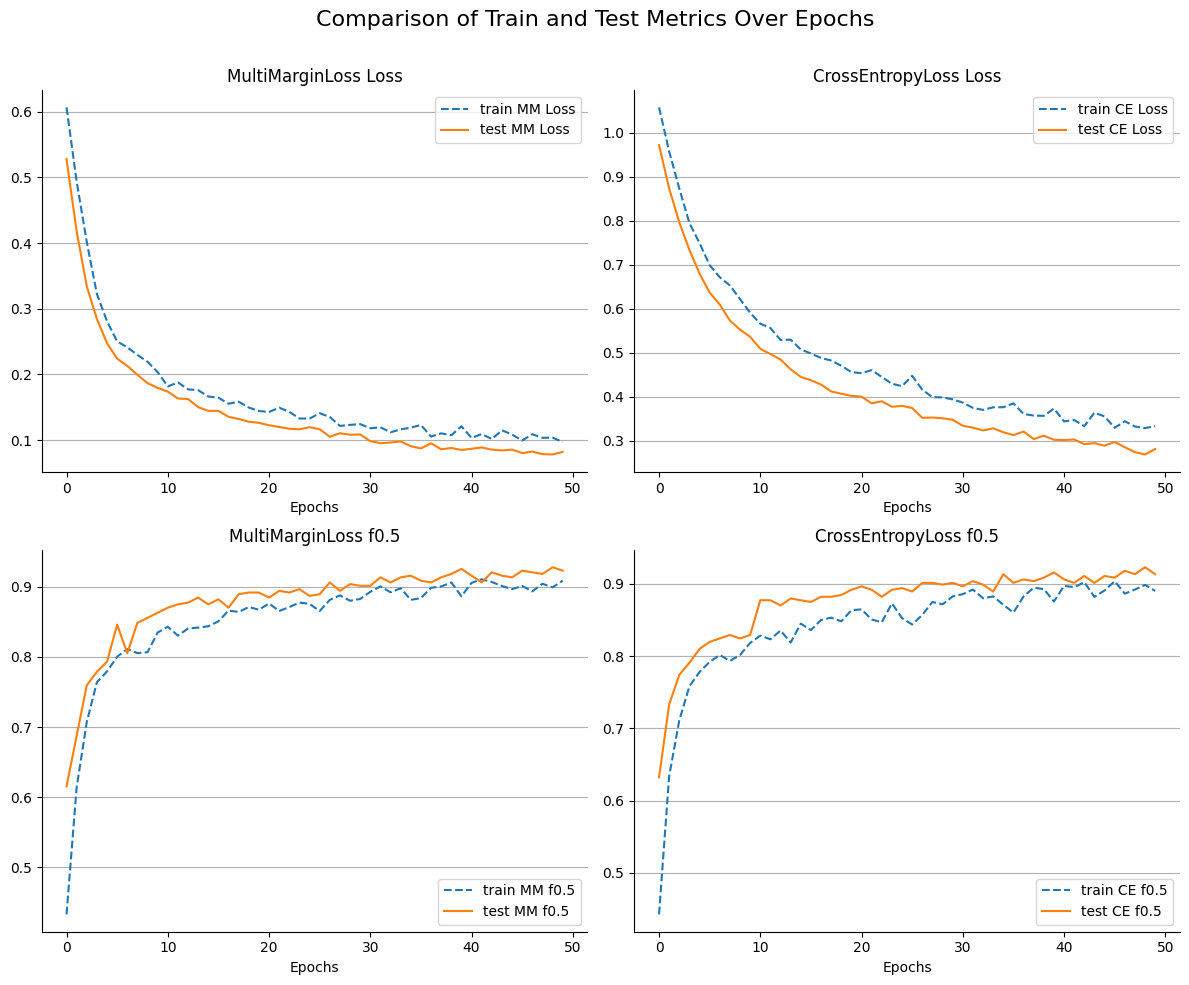

In [41]:
import matplotlib.pyplot as plt

def plot_curves(results_mm, results_ce):
    metric_names = [("loss", "Loss"), ("fbeta_score", "f0.5")]
    epochs = range(len(results_mm["train_loss"]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Comparison of Train and Test Metrics Over Epochs", fontsize=16)

    for row, (metric, label) in enumerate(metric_names):
        # Plot results for MultiMarginLoss
        axes[row, 0].plot(epochs, results_mm[f"train_{metric}"], label=f"train MM {label}", linestyle='--')
        axes[row, 0].plot(epochs, results_mm[f"test_{metric}"], label=f"test MM {label}")
        axes[row, 0].set_title(f"MultiMarginLoss {label}")
        axes[row, 0].set_xlabel("Epochs")
        axes[row, 0].legend()

        # Plot results for CrossEntropyLoss
        axes[row, 1].plot(epochs, results_ce[f"train_{metric}"], label=f"train CE {label}", linestyle='--')
        axes[row, 1].plot(epochs, results_ce[f"test_{metric}"], label=f"test CE {label}")
        axes[row, 1].set_title(f"CrossEntropyLoss {label}")
        axes[row, 1].set_xlabel("Epochs")
        axes[row, 1].legend()

        for ax in axes[row]:
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.grid(which="both", axis="y")
            ax.set_axisbelow(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the modified function with the results_mm and results_ce dictionaries
plot_curves(results_mm, results_ce)

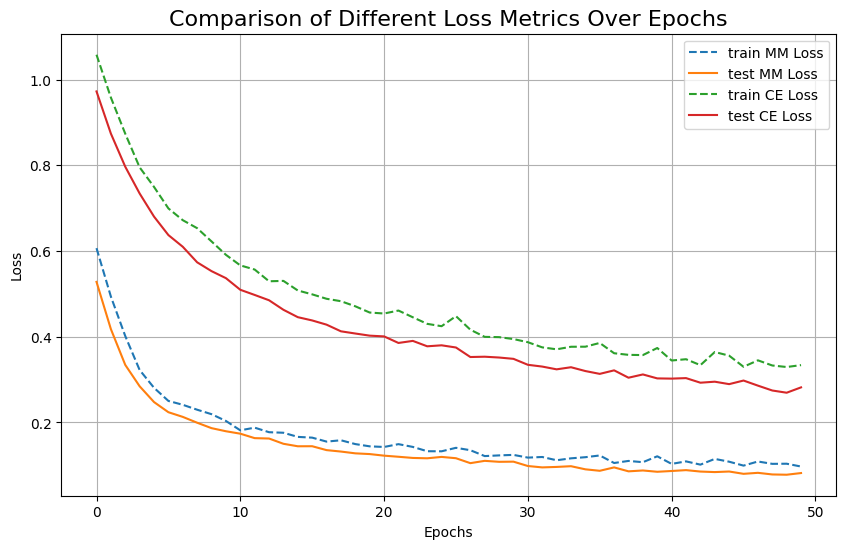

In [42]:
def plot_curves(results_mm, results_ce):
    metric_name = "loss"
    epochs = range(len(results_mm["train_loss"]))

    plt.figure(figsize=(10, 6))
    plt.title("Comparison of Different Loss Metrics Over Epochs", fontsize=16)

    plt.plot(epochs, results_mm[f"train_{metric_name}"], label="train MM Loss", linestyle='--')
    plt.plot(epochs, results_mm[f"test_{metric_name}"], label="test MM Loss")
    plt.plot(epochs, results_ce[f"train_{metric_name}"], label="train CE Loss", linestyle='--')
    plt.plot(epochs, results_ce[f"test_{metric_name}"], label="test CE Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the modified function with the results_mm and results_ce dictionaries
plot_curves(results_mm, results_ce)



*   From the graph, the train MM Loss curve decreases more rapidly compared to the train CE Loss curve. This shows that `MultiMarginLoss` learns faster on the training data, so we will use `MultiMarginLoss` in our model.



In [5]:
full_data_dir = "data/Full  Water level"
half_data_dir = "data/Half water level"
overflowing_data_dir = "data/Overflowing"
class_names=["full", "half", "overflowing"]

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model_path = Path("models/")
model_path.mkdir(parents=True,exist_ok=True)

In [8]:
EPOCH = 100
LR = 1e-4
BATCH_SIZE=32

In [12]:
!rm -rf data/

In [13]:
with zipfile.ZipFile("water_bottle_level.zip") as z:
  z.extractall(data_path)

In [9]:
class ModelTrainer:
    def __init__(self, model_name, num_classes, num_epochs, learning_rate, batch_size):
        self.model_name = model_name
        self.num_classes = num_classes
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def create_model(self):
        model, data_transform = model_builder.create_model(model_name=self.model_name, num_classes=self.num_classes)
        return model, data_transform

    def augment_datasets(self, *class_dirs):
        for class_dir in class_dirs:
            data_setup.augment_dataset(class_dir=class_dir)

    def setup_dataframes(self, data_path):
        train_df, test_df = data_setup.create_dataframe(data_path=data_path)
        return train_df, test_df

    def setup_dataloaders(self, train_dir, test_dir, data_transform):
        train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            transform=data_transform,
            batch_size=self.batch_size,
        )
        return train_dataloader, test_dataloader, class_names

    def create_writer(self):
        timestamp = datetime.now().strftime("%d-%m-%Y,%H-%M-%S")
        log_dir_parts = ["runs", timestamp, self.model_name, f"{self.num_epochs}_epochs", f"{self.learning_rate}_lr"]
        log_dir = os.path.join(*log_dir_parts)
        print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
        return SummaryWriter(log_dir=log_dir)

    def train_model(self):
      model, data_transform = self.create_model()
      self.augment_datasets(full_data_dir, half_data_dir, overflowing_data_dir)
      train_df, test_df = self.setup_dataframes(data_path)
      train_dataloader, test_dataloader, class_names = self.setup_dataloaders(train_df, test_df, data_transform)
      writer = self.create_writer()
      fbeta_score = FBetaScore(task="multiclass", num_classes=len(class_names), beta=0.5).to(device)

      # Set the loss function and optimizer
      mm_loss = torch.nn.MultiMarginLoss()
      optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)

      # Start the timer
      start_time = timer()

      # Starting training
      results = engine.train(
          model=model,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          optimizer=optimizer,
          loss_fn=mm_loss,
          epochs=self.num_epochs,
          fbeta_score=fbeta_score,
          device=device,
          writer=writer,
      )

      # End the timer and print out how long it took
      end_time = timer()
      print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
      print("-" * 50 + "\n")

      return results,model,data_transform


## EfficientNetB0

In [14]:
effnet_trainer = ModelTrainer(model_name="EfficientNet_B0", num_classes=3, num_epochs=EPOCH, learning_rate=LR, batch_size=BATCH_SIZE)

In [15]:
effnetb0_results,effnetb0_model,effnetb0_data_transform=effnet_trainer.train_model()

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] Created SummaryWriter, saving to: runs/25-08-2023,15-24-28/EfficientNet_B0/100_epochs/0.0001_lr...


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [32, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:26.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [4, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to ze

Epoch: 1 
 train_loss: 0.6055 | train_f0.5_score: 44.0% | 
 test_loss: 0.5284 | test_f0.5_score: 62.0% | 
Epoch: 2 
 train_loss: 0.4932 | train_f0.5_score: 61.0% | 
 test_loss: 0.4149 | test_f0.5_score: 70.0% | 
Epoch: 3 
 train_loss: 0.3953 | train_f0.5_score: 70.0% | 
 test_loss: 0.3260 | test_f0.5_score: 75.0% | 
Epoch: 4 
 train_loss: 0.3236 | train_f0.5_score: 76.0% | 
 test_loss: 0.2796 | test_f0.5_score: 78.0% | 
Epoch: 5 
 train_loss: 0.2834 | train_f0.5_score: 78.0% | 
 test_loss: 0.2401 | test_f0.5_score: 80.0% | 
Epoch: 6 
 train_loss: 0.2562 | train_f0.5_score: 79.0% | 
 test_loss: 0.2259 | test_f0.5_score: 84.0% | 
Epoch: 7 
 train_loss: 0.2405 | train_f0.5_score: 81.0% | 
 test_loss: 0.2109 | test_f0.5_score: 86.0% | 
Epoch: 8 
 train_loss: 0.2197 | train_f0.5_score: 81.0% | 
 test_loss: 0.2059 | test_f0.5_score: 81.0% | 
Epoch: 9 
 train_loss: 0.2121 | train_f0.5_score: 82.0% | 
 test_loss: 0.1907 | test_f0.5_score: 81.0% | 
Epoch: 10 
 train_loss: 0.2041 | train_f0.5_sc

In [16]:
train_df,test_df = effnet_trainer.setup_dataframes(data_path)

In [17]:
#  Creating a function to make predictions across the test dataseT
def pred_and_store(test_paths, model, transform, class_names, device):
    predictions = []

    for index, row in test_paths.iterrows():
            prediction_dict = {}

            # Get the sample path and ground truth class name
            path = row['path']  # Replace 'path_column_name' with the actual column name
            ground_truth_class = row['classes']  # Replace 'ground_truth_column_name'

            start_time = timer()

            img = Image.open(path)
            transformed_image = transform(img).unsqueeze(0).to(device)

            model.to(device)
            model.eval()

            with torch.inference_mode():
                pred_logit = model(transformed_image)
                pred_prob = torch.softmax(pred_logit, dim=1)
                pred_label = torch.argmax(pred_prob, dim=1)
                pred_class = class_names[pred_label.cpu()]

                prediction_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
                prediction_dict["pred_class"] = pred_class

                end_time = timer()
                prediction_dict["time_for_pred"] = round(end_time-start_time, 4)
            prediction_dict["correct"] = ground_truth_class == pred_class
            predictions.append(prediction_dict)
    return predictions

In [46]:
def get_model_stats(
    models_dir, results, test_data, model,model_name, transform, class_names,epoch,lr,device
):
    model_filepath = f"{model_name}_{epoch}_epochs_{lr}_lr.pth"
    utils.save_model(model=model,
                 target_dir=models_dir,
                 model_name=model_filepath)
    pretrained_model_size = Path(f"/content/models/{model_filepath}").stat().st_size / (1024 * 1024)

    total_params = sum(torch.numel(param) for param in model.parameters())

    pred_dicts = pred_and_store(
        test_paths=test_data,
        model=model,
        transform=transform,
        class_names=class_names,
        device=device,
    )

    pred_df = pd.DataFrame(pred_dicts)
    average_time_per_pred = round(pred_df.time_for_pred.mean(), 4)

    model_stats = {
        "test_loss": results["test_loss"][-1],
        "test_f0.5_score": results["test_fbeta_score"][-1],
        "total_parameters": total_params,
        "model_size (MB)": pretrained_model_size,
        "average_time_per_prediction": average_time_per_pred,
    }

    return model_stats

In [29]:
model_dir="/content/models"

In [47]:
effnetb0_model_stats = get_model_stats(
    models_dir=model_dir, results=effnetb0_results, test_data=test_df, model=effnetb0_model,model_name="EfficientNetB0", transform=effnetb0_data_transform, class_names=class_names,epoch=EPOCH,lr=LR,device=device
)

[INFO] Saving model to: /content/models/EfficientNetB0_100_epochs_0.0001_lr.pth


## ResNet18

In [ ]:
!rm -rf data/

In [ ]:
with zipfile.ZipFile("water_bottle_level.zip") as z:
  z.extractall(data_path)

In [ ]:
resnet18_trainer = ModelTrainer(model_name="ResNet18", num_classes=3, num_epochs=EPOCH, learning_rate=LR, batch_size=BATCH_SIZE)

In [ ]:
train_df,test_df = resnet18_trainer.setup_dataframes()

In [ ]:
resnet18_results,resnet18_model,resnet18_data_transform = resnet18_trainer.train_model()

In [ ]:
resnet18_model_stats = get_model_stats(
    model_path, resnet18_results, test_df, resnet18_model, resnet18_data_transform, class_names
)

## GoogLeNet

In [ ]:
!rm -rf data/

In [ ]:
with zipfile.ZipFile("water_bottle_level.zip") as z:
  z.extractall(data_path)

In [ ]:
googlenet_trainer = ModelTrainer(model_name="GoogLeNet", num_classes=3, num_epochs=EPOCH, learning_rate=LR, batch_size=BATCH_SIZE)

In [ ]:
train_df,test_df = googlenet_trainer.setup_dataframes()

In [ ]:
googlenet_results,googlenet_model,googlenet_data_transform = googlenet_trainer.train_model()

In [ ]:
googlenet_model_stats = get_model_stats(
    model_path, googlenet_results, test_df, googlenet_model, googlenet_data_transform, class_names
)

## Model Comparison

In [ ]:
df = pd.DataFrame([effnetb0_model_stats, resnet18_model_stats,googlenet_model_stats])

# Add column for model names
df["model"] = ["EffNetB0", "ResNet18", "GoogLeNet"]

# Convert accuracy to percentages
df["test_f0.5_score"] = round(df["test_fbeta_score"] * 100, 2)

df

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model.to(device)
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


In [ ]:
targets=test_data_transformed.targets
mapping = {'full': 0, 'half': 1, 'overflowing': 2}
targets = np.array([mapping[i] for i in targets])

In [ ]:
clf_report = classification_report(targets, y_pred_tensor.cpu().numpy(),
        target_names=class_names)
print(clf_report)

              precision    recall  f1-score   support

        full       0.83      0.80      0.81       151
        half       0.79      0.80      0.80       127
 overflowing       0.89      0.92      0.90       108

    accuracy                           0.83       386
   macro avg       0.84      0.84      0.84       386
weighted avg       0.83      0.83      0.83       386



Text(0.5, 1.0, 'Confusion Matrix')

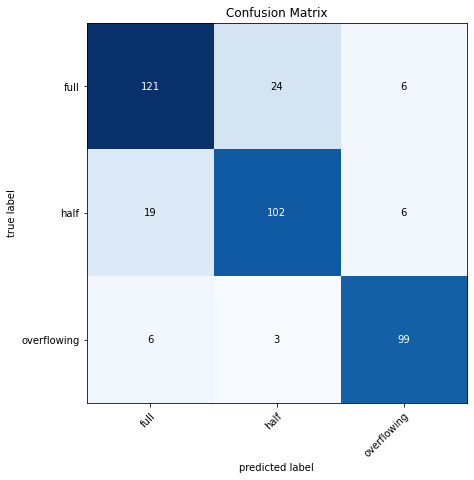

In [ ]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=torch.from_numpy(targets).type(torch.float)
                         )

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names, #
    figsize=(10, 7))
ax.set_title("Confusion Matrix")

In [ ]:
from typing import List, Tuple
def pred_and_plot_image(model: torch.nn.Module,
                        image_path : str,
                        class_names: List[str],
                        image_size: Tuple[int,int]=(224,224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = torchvision.transforms.Compose([transforms.Resize(image_size),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(mean=[0.485,0.456,0.406],
                                                                               std=[0.229,0.224,0.225]) ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)

        target_image_pred = model(transformed_image).to(device)
    target_image_pred_prob = torch.softmax(target_image_pred,dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_prob,dim=1)


    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_prob.max():.3f}")
    plt.axis(False)

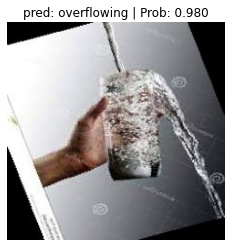

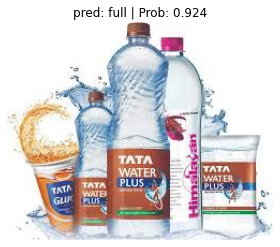

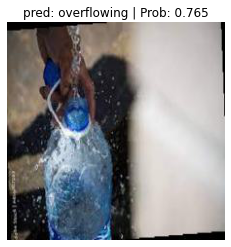

In [ ]:
import random
num_images_to_plot=3
val_image_path_list = list(test_df["path"])
val_image_path_sample = random.sample(population=val_image_path_list,k=num_images_to_plot)
for image_path in val_image_path_sample:
    pred_and_plot_image(model=model,image_path=image_path,class_names=class_names,image_size=(224,224),device=device)
